# Notebook for demonstrative example

This notebook reproduces the plots found in the accompanying paper, and loads parameters from a cached output file. Experiments can be re-produced using the scripts found in the above directory. This will also generate additional run-time plots using WandB logging callbacks.

In [2]:
import umap
import numpy as np
import pickle as pkl
import torch
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
import palettable
from palettable.tableau import Tableau_20
from hydra import compose, initialize
from omegaconf import OmegaConf

import os
from pathlib import Path
import sys
node_type = os.getenv('BB_CPU')
venv_dir = f'/rds/homes/g/gaddcz/Projects/waveletVAE/my-virtual-env-{node_type}'  # edit this line to match the venv directory format
venv_site_pkgs = Path(venv_dir) / 'lib' / f'python{sys.version_info.major}.{sys.version_info.minor}' / 'site-packages'
if venv_site_pkgs.exists():
    sys.path.insert(0, str(venv_site_pkgs))
    print(f"Loaded venv for {node_type}")
else:
    print(f"Path '{venv_site_pkgs}' not found. Check that it exists and/or that it exists for node-type '{node_type}'.")

%load_ext autoreload
%autoreload 2

Loaded venv for icelake
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from SignalTransformData.sinusoidal.loader import SinusoidalDataModule
from SignalTransformData.sinusoidal.generate import SimulateSinusoidal, demo_config
from waveletVAE.src.WaveLSTM.models.base import WaveletBase as SourceSeparation

sns.set()
# sns.set_palette(Tableau_20.mpl_colors)
sns.set_palette(sns.color_palette("Paired"))

%matplotlib inline

## Config

In [4]:
## Get config
with initialize(version_base=None, config_path="../confs", job_name="sim_clf_inference"):
    config = compose(config_name="classifier_config")

print(OmegaConf.to_yaml(config))

data:
  batch_size: 256
experiment:
  project_name: WaveLSTM-clf
  num_epochs: 30
  run_id: ${encoder.base.method}_${experiment.seed}
  save_file: outputs/${experiment.run_id}.pkl
  train: true
  verbose: true
  seed: 42
encoder:
  base:
    D: 10
    method: waveLSTM
  waveLSTM:
    wavelet: haar
    J: 10
    r_hops: 1
    attention_unit: 350
    layers: 1
    hidden_channels: 64
    proj_size: 5
classifier:
  nfc: 256



# Get data

In [5]:
dm = SinusoidalDataModule(**config.data)
for batch in dm.train_dataloader():
    break
print(batch['CNA'].shape)

torch.Size([256, 2, 512])


In [6]:
length = 512
channels = 2
discrete = True
generator = SimulateSinusoidal(demo_config(), discretise=discrete)
generator(samples=2000, sig_length=length)

# Plotting data (noise free)
_, unique_lbls = np.unique(generator.labels, return_index=True)
X = generator.signals_no_noise[unique_lbls, :, :].reshape(6,-1)

save_path = "figs/discrete/" if discrete else "figs/cont/"

In [7]:
print(demo_config())

{'bias': [[-0.5, 0.5], [0.5, -0.5], [-0.5, 0.5], [-0.5, 0.5], [0, 0], [0, 0]], 'base_angular_freq': [[3.141592653589793, 6.283185307179586], [3.141592653589793, 6.283185307179586], [3.141592653589793, 3.141592653589793], [3.141592653589793, 3.141592653589793], [9.42477796076938, 6.283185307179586], [9.42477796076938, 6.283185307179586]], 'base_amplitude': [[0.5, 0.5], [0.5, 0.5], [0.0, 0.5], [0.0, 0.5], [0.5, 0.5], [0.5, 0.5]], 'transient_bool': [False, False, False, True, False, False], 'transient_start': [[nan, nan], [nan, nan], [nan, nan], [125, 275], [nan, nan], [nan, nan]], 'transient_amplitude': [[nan, nan], [nan, nan], [nan, nan], [0.5, -0.5], [nan, nan], [nan, nan]], 'singularity_bool': [False, False, False, False, False, True], 'singularity_start': [[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [50, 300]], 'singularity_amplitude': [[nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [-0.5, 0.5]]}


### and put into a dataframe for Seaborn

In [8]:
data = []

# Class 1 and 2
# No distinction in resolution sources
for res in ["Low-resolution", "Mid-resolution", "High-resolution"]:
    for cls in [0, 1]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])

# Class 3 and 4
# Distinction at middle resolution
for res in ["Low-resolution"]:
    for cls in [2, 3]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[2, i]])
for res in ["Mid-resolution", "High-resolution"]:
    for cls in [2, 3]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])

# Class 5 and 6
# Distinction at high resolution
for res in ["Low-resolution", "Mid-resolution"]:
    for cls in [4, 5]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[4, i]])
for res in ["High-resolution"]:
    for cls in [4, 5]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])
            
df = pd.DataFrame(data, columns=["loci", "resolution", "class", "signal"])
df.head()            

,loci,resolution,class,signal
0,0,Low-resolution,1,2
1,1,Low-resolution,1,1
2,2,Low-resolution,1,1
3,3,Low-resolution,1,1
4,4,Low-resolution,1,1


### Plot data

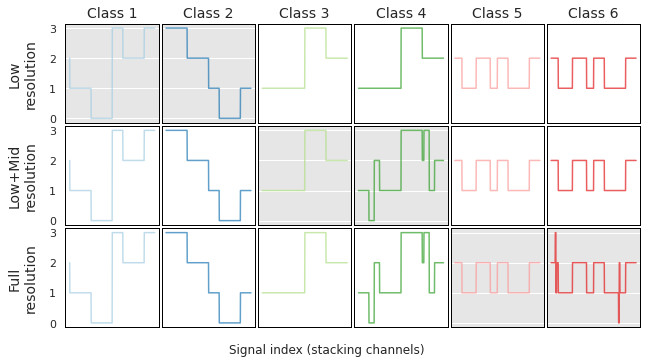

<Figure size 432x288 with 0 Axes>

In [9]:
g = sns.FacetGrid(df, col="class", row="resolution", hue="class", margin_titles=True, despine=False, height=2, aspect=0.8)
g.map(sns.lineplot, "loci", "signal", alpha=.7)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="Class {col_name}", row_template="", size=14)    # {row_name}

for ax,l in zip(g.axes[:,0], ["Low\nresolution", "Low+Mid\nresolution", "Full\nresolution"]):
    ax.set_ylabel(l, fontsize=14, rotation=90)  #      ha='right', va='center', fontweight='bold'
    ax.yaxis.set_label_coords(-0.3, 0.5)

    
g.set_xlabels(label="", clear_inner=True, )
g.fig.supxlabel("Signal index (stacking channels)")

for ax in g.axes.flatten():
    for _, spine in ax.spines.items():
        spine.set_visible(True) 
        spine.set_color('black')
        spine.set_linewidth(1)
        
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == "Low-resolution" and (col_val == 1 or col_val == 2):
        ax.set_facecolor(".9")
    elif row_val == "Mid-resolution" and (col_val == 3 or col_val == 4):
        ax.set_facecolor(".9")
    elif row_val == "High-resolution" and (col_val == 5 or col_val == 6):
        ax.set_facecolor(".9")
    else:
        ax.set_facecolor((0, 0, 0, 0))
    ax.set_xticks([])


# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
plt.gcf().set_size_inches(9, 5)
plt.show()
plt.savefig(save_path + "data.png", dpi=500, format='png')

# Model visualisations

Load saved model

Additional visualisation are provided at run-time with WandB logging callbacks.

In [76]:
# with open("../logs/a-ae-output.pkl", 'rb') as file:
with open("../outputs/waveLSTM_42.pkl", 'rb') as file:
    meta_results = pkl.load(file)

# wave-LSTM outputs    
J = len(meta_results["resolution_embeddings"])
lbls = meta_results["labels"].detach().cpu().numpy()
Mbar = np.mean(meta_results["M"], axis=1)
Mflat = meta_results["M"].reshape(meta_results["M"].shape[0], -1)
A = meta_results["attention"]

print(f"Available outputs: {[i for i in meta_results.keys()]}")

Available outputs: ['masked_inputs', 'masked_targets', 'resolution_embeddings', 'attention', 'M', 'labels']


# Source-separation module

Visualise the source-separated inputs.

Any discrete wavelet can be used. We used the Haar wavelet throughout for simplicity, but different wavelets may suit different tasks.

Original (noise-free) input signal


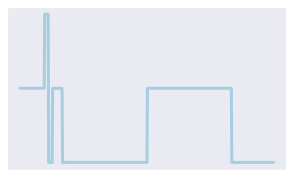

Source-separated input signals


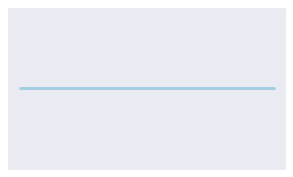

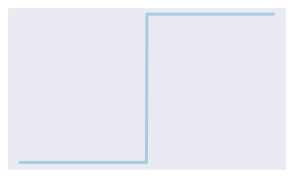

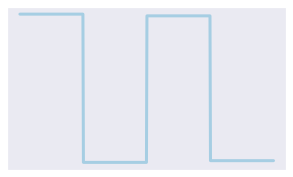

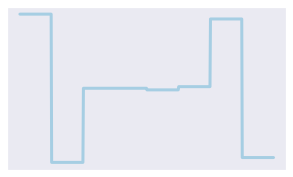

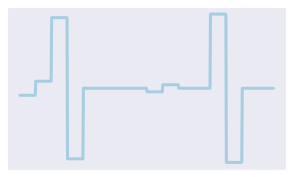

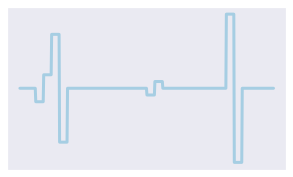

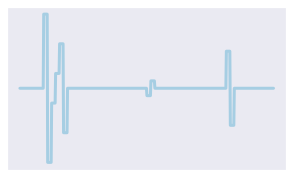

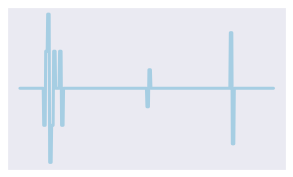

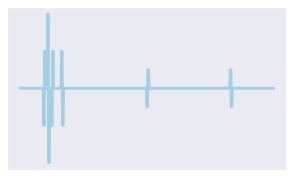

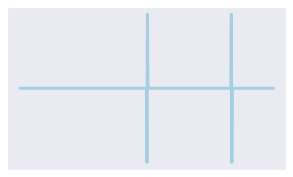

In [73]:
channel = 1                  # 1 or 2
cls = 6                      # 1,2,...,6
paper = True                # paper-ready plots

X = generator.signals_no_noise[unique_lbls, :, :]

print("Original (noise-free) input signal")
plt.figure(figsize=(5,3))
plt.plot(np.linspace(0, length, length), X[cls-1, channel-1, :], lw=3)
if paper:
    plt.xticks([]); plt.yticks([])
    plt.savefig(save_path + f"input_c{channel}.png", dpi=500, format='png', transparent=True); 
plt.show()

print("Source-separated input signals")
source_separation_layer = SourceSeparation(input_size=length, input_channels=channels, 
                                           recursion_limit=config.encoder.waveLSTM.J, 
                                           wavelet=config.encoder.waveLSTM.wavelet)
masked_inputs, _ = source_separation_layer(torch.from_numpy(X).to(torch.float32))
masked_inputs = [m_i.detach().cpu().numpy() for m_i in masked_inputs]

loci = masked_inputs[0].shape[-1]
for j in range(len(masked_inputs)):
    plt.figure(figsize=(5,3))
    plt.plot(np.linspace(0, loci, loci), masked_inputs[j][cls-1, channel-1, :], lw=3)
    if paper:
        plt.xticks([]); plt.yticks([])
        plt.savefig(save_path + f"source_sep_input_c{channel}j{j+1}.png", dpi=500, format='png', transparent=True)


# Visualise Wave-LSTM encoder output

In [72]:
reduce_method = "tSNE"         # tSNE or umap

if reduce_method.lower() == "umap":
    reducer = umap.UMAP()
elif reduce_method.lower() == "tsne":
    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30)
else:
    raise NotImplementedError

# axis labels
latent1 = f"{reduce_method}-1"
latent2 = f"{reduce_method}-2"

## Resolution-embeddings (vs. source-separated inputs)

We visualise the learnt $h_j$, and compare how this differs from source-separated input $X_j$. 

In [77]:
data = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["resolution_embeddings"][j_res]
    x_j = meta_results["masked_inputs"][j_res]

    # Projection of scale embeddings, and source separated input
    for val, val_name in zip([h_j, x_j], ["m_j", "X_j"]):

        val = val.reshape((val.shape[0], -1))           # Reshape x_j to flatten channels
        val = StandardScaler().fit_transform(val)       # Scale before any transform
        
        embedding = reducer.fit_transform(val)
        for i in range(embedding.shape[0]):
            data.append([embedding[i, 0], embedding[i, 1], 
                         val_name,
                         j_name, lbls[i] + 1,
                         False if lbls[i] % 2 == 0 else True
                        ])  

df_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "resolution", "Class", "Artifact"])
display(df_emb.head())


,tSNE-1,tSNE-2,source,resolution,Class,Artifact
0,-15.733385,5.352382,m_j,1,4,True
1,20.942894,-9.942022,m_j,1,5,False
2,7.726174,23.506214,m_j,1,2,True
3,14.280733,-7.993230,m_j,1,5,False
4,-15.861744,4.208635,m_j,1,4,True


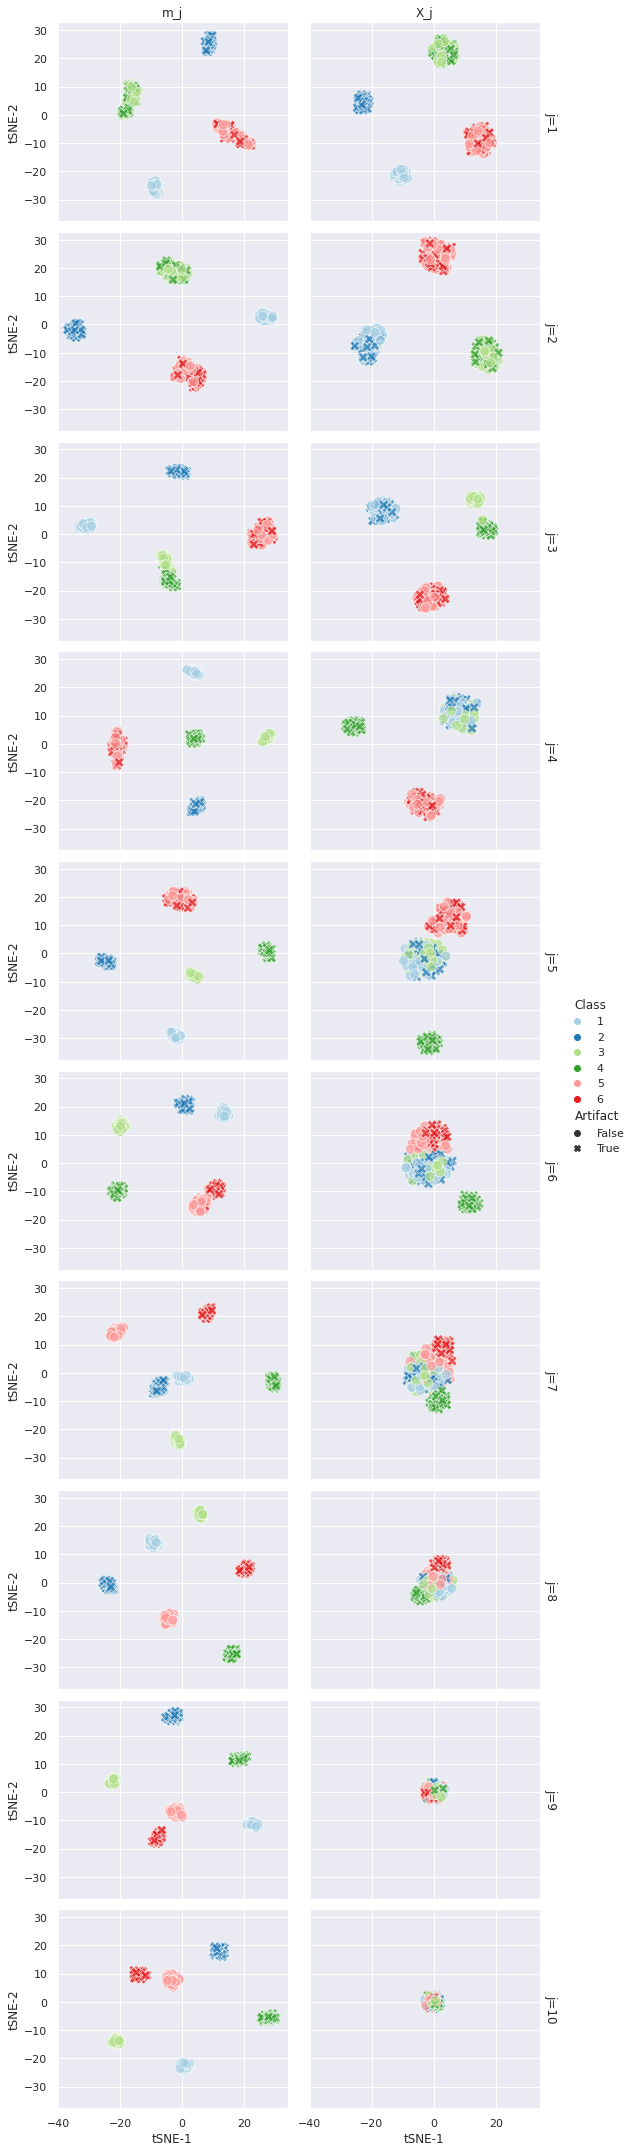

In [78]:
g = sns.relplot(data=df_emb, x=latent1, y=latent2,  row="resolution", col="source", hue="Class", 
                style="Artifact", style_order=[False, True],
                legend="auto", s=100, alpha=0.7,
                height=3, aspect=4/3,
                palette="Paired",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}", col_template="{col_name}")
plt.show()


We find that $h_j$ benefits from the information flow through the LSTM model. Embeddings are improved by

* the additional label/task information, leading to adaptive filtering.
* the ability of the LSTM model to pass information through the recurrent cell states. E.g. Whilst the orange class was separable at $X_{j=4}$, and subsequently not - within the resolution embeddings that information has been retained for $h_{j\geq4}$. Note, this behaviour can be controlled through reducing and increasing the capacity of the hidden states.


## Plot selective resolution embeddings (paper plot)

This is the paper plot version of the above section

['$X_{j=2}$', '$X_{j=4}$', '$X_{j=5}$', '$X_{j=7}$', '$m_{j=2}$', '$m_{j=4}$', '$m_{j=5}$', '$m_{j=7}$']


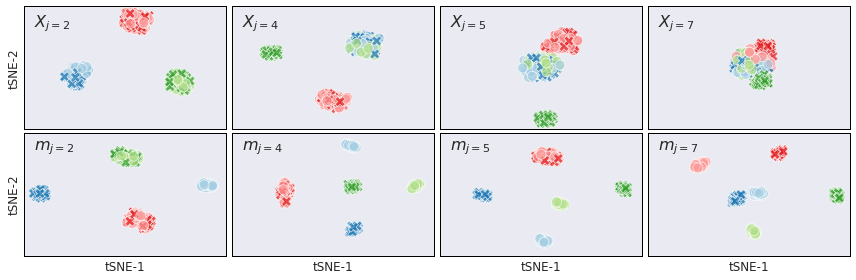

In [82]:
resolutions = [2,4,5,7]         # 1,2,3,...,J=7
sources = ["X_j", "m_j"]

df_fig2 = df_emb[df_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig2 = df_fig2[df_fig2["source"].isin(sources)]
# df_fig2 = df_fig2[df_fig2["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.relplot(data=df_fig2, x=latent1, y=latent2,  row="source", col="resolution", hue="Class", 
                row_order=sources,
                style="Artifact", style_order=[False, True],
                legend=False, s=100, alpha=0.7,
                height=2, aspect=1.5,
                palette="Paired",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")
    

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=f"{reduce_method}-1", clear_inner=True)
g.set_ylabels(label=f"{reduce_method}-2", clear_inner=True)

spaces = []
tmp1 = r"_{j="
tmp2 = r"}"
[[ spaces.append(f"${i[0]}{tmp1}{j}{tmp2}$") for j in resolutions] for i in sources] 
# spaces = [[ for j in resolutions] for i in sources].flatten()
print(spaces)
for ax, space in zip(g.axes.flatten(), spaces ):  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    # ax.set_facecolor((0, 0, 0, 0))
    
    if j is not None:
        ax.text(.05, .95, f'{space}', ha='left', va='top', transform=ax.transAxes, size=16)

# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.gcf().set_size_inches(8, 3.5)
        
plt.savefig(save_path + "resolution_embeddings.png", dpi=500, format='png', transparent=True)

## Visualisation of self-attention

We can also visualise the learnt self-attention, allowing us to see which resolutions the model thought were predictive.

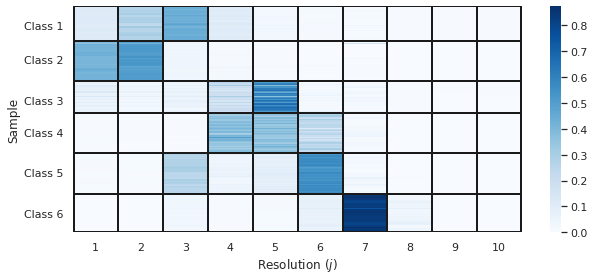

In [85]:
# Order samples by label
permute_idx = np.argsort(lbls)
ord_lbls = lbls[permute_idx]
ord_attention = A[permute_idx, :, :]

# average over attention hops:   [batch_size, num_multiscales]
ord_attention = np.mean(ord_attention, axis=1)

# Nested ordering (by biclustering attention)
attention_new = np.zeros_like(ord_attention)
for _lbl in np.unique(ord_lbls):
    lbl_idx = np.where(ord_lbls == _lbl)[0]
    atn_cls = ord_attention[lbl_idx, :]
    biclustering = SpectralBiclustering(n_clusters=(ord_attention.shape[1], 1), method="log", random_state=0)
    biclustering.fit(atn_cls)
    atn_cls = atn_cls[np.argsort(biclustering.row_labels_)]
    attention_new[lbl_idx, :]  = atn_cls#[:, np.argsort(biclustering.column_labels_)]
attention = attention_new

# Plot
fig, ax = plt.subplots(1, 1, figsize=(9,4))
sns.heatmap(attention, ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1

# Add horizontal lines
y_tick_locations = [np.where(ord_lbls == _lbl)[0][0] for _lbl in np.unique(ord_lbls)]
for y_tick in y_tick_locations:
    ax.hlines(y=y_tick+0.1, xmin=0, xmax=20, linewidth=2, color='k')
ax.hlines(y=attention.shape[0]-0.1, xmin=0, xmax=20, linewidth=2, color='k')

# Add vertical lines
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')
ax.vlines(x=attention.shape[1]-0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')

    
ax.set_yticks([yi+attention.shape[0]/12 for yi in y_tick_locations])
# ax.set_yticks([], minor=True)
# ax.yaxis.grid(True, which='major', lw=1, ls='-', color='k')
ax.set_yticklabels([f"Class {i+1}" for i in np.unique(ord_lbls)])
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)

ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Sample")    # permuted

plt.tight_layout()
plt.savefig(save_path + "attention.png", dpi=500, format='png', transparent=True)

## Visualisation of the multi-resolution embedding

We can visualise the embedding tensor $M$ by either flattening, or taking the average across hops. For this example $r_{\text{hops}}=1$, and so they are equivalent.

,tSNE-1,tSNE-2,source,Class,Artifact
0,-0.513513,0.024591,Mflat,4,True
1,23.874571,6.544982,Mflat,5,False
2,-22.921984,5.383025,Mflat,2,True
3,23.174585,5.050080,Mflat,5,False
4,0.264842,0.384658,Mflat,4,True


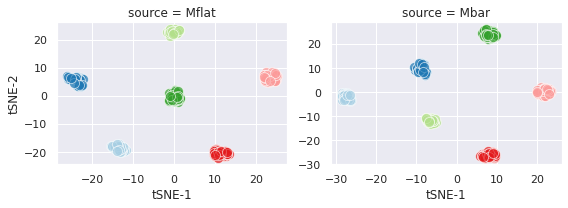

In [86]:
data = []

for Mvar, Mname in zip([Mflat, Mbar], ["Mflat", "Mbar"]):

    embedding = reducer.fit_transform(Mvar.reshape((Mvar.shape[0], -1)))

    for i in range(embedding.shape[0]):
        data.append([embedding[i, 0], embedding[i, 1], 
                     Mname,
                     lbls[i] + 1,
                     False if lbls[i] % 2 == 0 else True
                    ])  

df_mres_emb = pd.DataFrame(data, columns=[latent1, latent2, "source", "Class", "Artifact"])
display(df_mres_emb.head())

# Plot
g = sns.FacetGrid(df_mres_emb, col="source", hue="Class", 
                  margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, latent1, latent2, alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)


## Plot flattened multi-resolution embeddings (in paper)

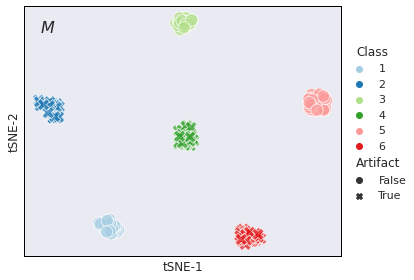

In [89]:
sources = ["Mflat"]

df_mres_emb = df_mres_emb[df_mres_emb["source"].isin(sources)]
# df_mres_emb = df_mres_emb[df_mres_emb["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.relplot(data=df_mres_emb, x=latent1, y=latent2,  col="source", hue="Class", 
                row_order=sources,
                style="Artifact", style_order=[False, True],
                legend=True, s=150, alpha=0.7,
                height=4, aspect=1,
                palette="Paired",
                facet_kws={'sharey': True, 'sharex': True, 'margin_titles': True, 'despine': False,}
               )
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="", col_template="")

leg = g._legend
leg.set_bbox_to_anchor([0.95, 0.85])
leg._loc = 2 

g.set_titles(col_template="", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label=latent1, clear_inner=True)
g.set_ylabels(label=latent2, clear_inner=True)

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    # ax.set_facecolor((0, 0, 0, 0))
    ax.text(.05, .95, r'$M$', ha='left', va='top', transform=ax.transAxes, size=16)

# Adjust margins
plt.tight_layout()
        
plt.savefig(save_path + "multires_emb_flat.png", dpi=500, format='png', bbox_inches='tight', transparent=True)